/tmp/ipykernel_3468704/1657292660.py:113: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, interval=500)


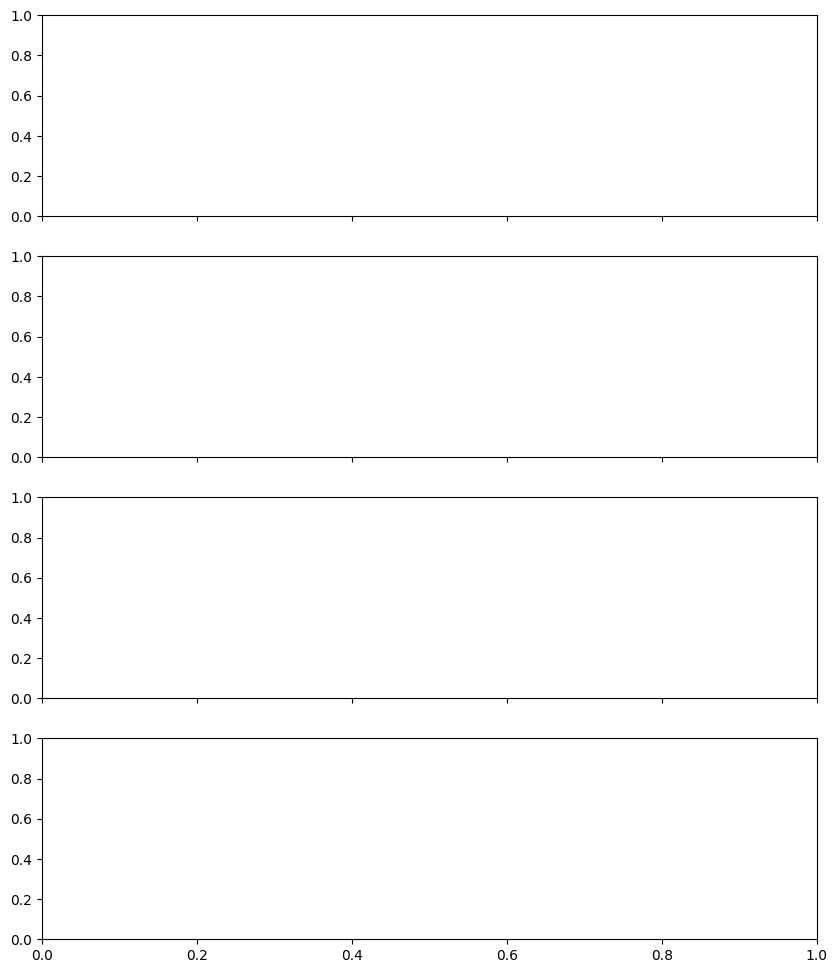

{'inflight': {'0': 0, '1': 0}, 'weights': {'0': 1.2249013764650671, '1': 0.9555282255485441}, 'service_rate': {'0': 45.50543485020129, '1': 36.92495315167098}, 'latency': {'decode': 0.5648442011812761, 'prefill': 0.42102916885693664}}
{'inflight': {'0': 26, '1': 21}, 'weights': {'0': 1.249901376465067, '1': 0.9805282255485441}, 'service_rate': {'0': 41.4362549373582, '1': 36.92495315167098}, 'latency': {'decode': 0.3078090176882816, 'prefill': 0.16411150969965013}}
{'inflight': {'0': 0, '1': 18}, 'weights': {'0': 1.2288017744865982, '1': 0.980528225548544}, 'service_rate': {'0': 51.128230036210184, '1': 26.090980979625254}, 'latency': {'decode': 0.6013958482463613, 'prefill': 0.4146397294069214}}
{'inflight': {'0': 1, '1': 0}, 'weights': {'0': 1.2538017744865981, '1': 1.005528225548544}, 'service_rate': {'0': 51.128230036210184, '1': 37.49917035808804}, 'latency': {'decode': 0.5840652720811729, 'prefill': 0.3392533539654719}}
{'inflight': {'0': 17, '1': 14}, 'weights': {'0': 1.27880177

In [1]:
# %% [markdown]
# # ORBIT Real-Time Metrics Plotter

# %% [code]
import asyncio
import httpx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# --- CONFIG ---
METRICS_URL = "http://127.0.0.1:8000/metrics"  # Change to your router address
POLL_INTERVAL = 0.5  # seconds

# --- HISTORY STORE ---
history = {
    "time": [],
    "inflight": {},      # node_id -> [values]
    "weights": {},       # node_id -> [values]
    "service_rate": {},  # node_id -> [values]
    "latency_decode": [],
    "latency_prefill": [],
}

start_time = None

# %% [code]
async def fetch_metrics(client):
    global start_time
    r = await client.get(METRICS_URL)
    data = r.json()
    print(data)
    if start_time is None:
        start_time = asyncio.get_event_loop().time()
    t = asyncio.get_event_loop().time() - start_time
    history["time"].append(t)

    # Decode inflight requests
    for node, q in data["inflight"].items():
        node = int(node)
        if node not in history["inflight"]:
            history["inflight"][node] = []
        history["inflight"][node].append(q)

    # MPC weights
    for node, w in data["weights"].items():
        node = int(node)
        if node not in history["weights"]:
            history["weights"][node] = []
        history["weights"][node].append(w)

    # Service rates
    for node, mu in data["service_rate"].items():
        node = int(node)
        if node not in history["service_rate"]:
            history["service_rate"][node] = []
        history["service_rate"][node].append(mu)

    # Latencies
    history["latency_decode"].append(data["latency"]["decode"])
    history["latency_prefill"].append(data["latency"]["prefill"])

# %% [code]
async def poll_metrics():
    async with httpx.AsyncClient(timeout=1.0) as client:
        while True:
            try:
                await fetch_metrics(client)
            except Exception as e:
                print("Error fetching metrics:", e)
            await asyncio.sleep(POLL_INTERVAL)

# %% [code]
# --- PLOTTER ---
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

def update(frame):
    axs[0].cla()
    axs[1].cla()
    axs[2].cla()
    axs[3].cla()

    t = history["time"]

    # Decode inflight
    for node, q in history["inflight"].items():
        axs[0].plot(t, q, label=f"Node {node}")
    axs[0].set_ylabel("Inflight requests")
    axs[0].legend()
    axs[0].grid(True)

    # MPC weights
    for node, w in history["weights"].items():
        axs[1].plot(t, w, label=f"Node {node}")
    axs[1].set_ylabel("MPC Weight")
    axs[1].grid(True)

    # Service rates
    for node, mu in history["service_rate"].items():
        axs[2].plot(t, mu, label=f"Node {node}")
    axs[2].set_ylabel("Service rate μ [req/s]")
    axs[2].grid(True)

    # Latency
    axs[3].plot(t, history["latency_decode"], label="Decode")
    axs[3].plot(t, history["latency_prefill"], label="Prefill")
    axs[3].set_ylabel("Latency [s]")
    axs[3].set_xlabel("Time [s]")
    axs[3].grid(True)
    axs[3].legend()

    fig.tight_layout()

ani = FuncAnimation(fig, update, interval=500)

# %% [code]
# --- RUN POLLING AND PLOT ---
# Run asyncio polling in background
loop = asyncio.get_event_loop()
loop.create_task(poll_metrics())

plt.show()
